# NCAAM Spread Coverage Network Rating

## Objective
Build network-based strength ratings using **spread coverage results** instead of win/loss results.
This measures which teams consistently outperform market expectations.

## Key Difference from Win-Based Rating
- **Win-based**: "Team A beat Team B by 14 points"
- **Spread-based**: "Team A covered by 5 points against a -9 spread"

## NCAAM-Specific Characteristics
- 350+ teams, sparse graph (most teams don't play each other)
- Strong conference clustering
- `margin_cap=12` (~12 pts max impact)
- `recency_decay=0.85` (faster decay, more variability)
- `learning_rate=0.03` (smaller due to sparse connections)

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from collections import defaultdict

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# NCAAM Spread Coverage Config
CONFIG = {
    'sport': 'NCAAM',
    'margin_cap': 12,        # ~12 pts max impact
    'recency_decay': 0.85,   # Faster decay, more variability
    'learning_rate': 0.03,   # Smaller due to sparse connections
    'iterations': 150,       # More iterations for sparse graph
    'tolerance': 0.0005,     # Tighter tolerance
    'min_games': 5           # Minimum games for reliable rating
}

print(f"Spread Coverage Config: {CONFIG}")

Spread Coverage Config: {'sport': 'NCAAM', 'margin_cap': 12, 'recency_decay': 0.85, 'learning_rate': 0.03, 'iterations': 150, 'tolerance': 0.0005, 'min_games': 5}


## Phase 1: Data Loading & Spread Data Validation

In [2]:
# Load NCAAM data
data_file = Path().resolve().parent / 'data' / 'results' / 'ncaam_season_results.xlsx'
df = pd.read_excel(data_file)

print(f"Loaded {len(df)} NCAAM games")
print(f"Date range: {df['game_date'].min().date()} to {df['game_date'].max().date()}")
print(f"\nColumns: {list(df.columns)}")

# Validate spread data availability
print(f"\nSpread Data Quality:")
print(f"  spread_result_difference available: {df['spread_result_difference'].notna().sum()} / {len(df)} games")
print(f"  Missing spread data: {df['spread_result_difference'].isna().sum()} games")

df.head()

Loaded 2280 NCAAM games
Date range: 2025-11-03 to 2026-01-05

Columns: ['game_date', 'home_team', 'away_team', 'closing_spread', 'home_score', 'away_score', 'spread_result_difference']

Spread Data Quality:
  spread_result_difference available: 2279 / 2280 games
  Missing spread data: 1 games


,game_date,home_team,away_team,closing_spread,home_score,away_score,spread_result_difference
0,2025-11-03,Colorado Buffaloes,Montana St Bobcats,-12.5,84,78,-6.5
1,2025-11-03,Radford Highlanders,Western Illinois Leathernecks,-16.5,80,75,-11.5
2,2025-11-03,George Mason Patriots,Wofford Terriers,-14.5,70,46,9.5
3,2025-11-03,Baylor Bears,UT Rio Grande Valley Vaqueros,-24.5,96,81,-9.5
4,2025-11-03,Wisconsin Badgers,Campbell Fighting Camels,-20.5,96,64,11.5


In [3]:
# Prepare spread coverage data
# spread_result_difference: positive = home covered, negative = away covered

# Filter to games with spread data
df_spread = df[df['spread_result_difference'].notna()].copy()
print(f"Games with spread data: {len(df_spread)}")

# Determine cover team and fail team
df_spread['cover_team'] = np.where(
    df_spread['spread_result_difference'] >= 0,
    df_spread['home_team'],
    df_spread['away_team']
)
df_spread['fail_team'] = np.where(
    df_spread['spread_result_difference'] >= 0,
    df_spread['away_team'],
    df_spread['home_team']
)
df_spread['cover_margin'] = df_spread['spread_result_difference'].abs()

# Get all teams
all_teams = set(df_spread['home_team'].unique()) | set(df_spread['away_team'].unique())
print(f"Total teams: {len(all_teams)}")

# Count games per team
team_game_counts = {}
for team in all_teams:
    count = len(df_spread[(df_spread['home_team'] == team) | (df_spread['away_team'] == team)])
    team_game_counts[team] = count

# Filter to teams with minimum games
active_teams = {t for t, c in team_game_counts.items() if c >= CONFIG['min_games']}
print(f"Teams with {CONFIG['min_games']}+ games: {len(active_teams)}")

# Filter games to only include active teams
df_spread_filtered = df_spread[
    (df_spread['home_team'].isin(active_teams)) & 
    (df_spread['away_team'].isin(active_teams))
].copy()
print(f"Games between active teams: {len(df_spread_filtered)}")

# Distribution of cover margins
print(f"\nCover Margin Stats:")
print(df_spread_filtered['cover_margin'].describe())

Games with spread data: 2279
Total teams: 365
Teams with 5+ games: 365
Games between active teams: 2279

Cover Margin Stats:
count    2279.000000
mean        9.175296
std         7.229091
min         0.500000
25%         3.500000
50%         7.500000
75%        12.500000
max        54.500000
Name: cover_margin, dtype: float64


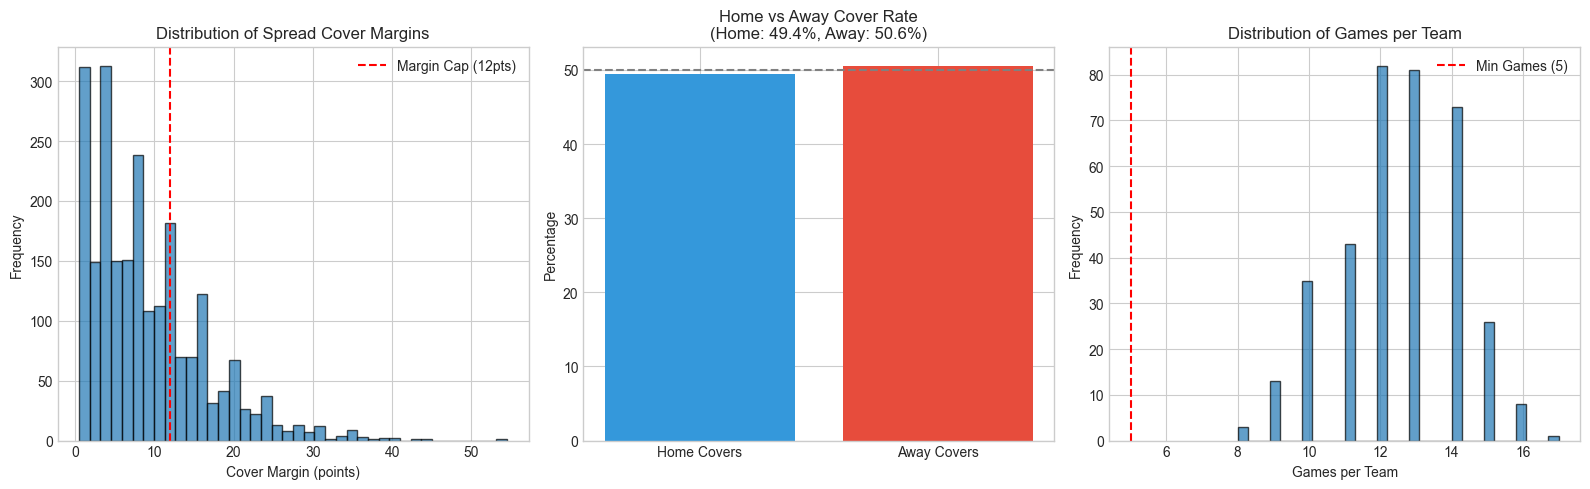

In [4]:
# Visualize spread coverage distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Cover margin distribution
axes[0].hist(df_spread_filtered['cover_margin'], bins=40, edgecolor='black', alpha=0.7)
axes[0].axvline(x=CONFIG['margin_cap'], color='r', linestyle='--', label=f"Margin Cap ({CONFIG['margin_cap']}pts)")
axes[0].set_xlabel('Cover Margin (points)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Spread Cover Margins')
axes[0].legend()

# Home vs Away cover rate
home_covers = (df_spread_filtered['spread_result_difference'] >= 0).mean() * 100
away_covers = (df_spread_filtered['spread_result_difference'] < 0).mean() * 100
axes[1].bar(['Home Covers', 'Away Covers'], [home_covers, away_covers], color=['#3498db', '#e74c3c'])
axes[1].axhline(y=50, color='gray', linestyle='--')
axes[1].set_ylabel('Percentage')
axes[1].set_title(f'Home vs Away Cover Rate\n(Home: {home_covers:.1f}%, Away: {away_covers:.1f}%)')

# Games per team distribution
game_counts = list(team_game_counts.values())
axes[2].hist(game_counts, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(x=CONFIG['min_games'], color='r', linestyle='--', label=f"Min Games ({CONFIG['min_games']})")
axes[2].set_xlabel('Games per Team')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Games per Team')
axes[2].legend()

plt.tight_layout()
plt.show()

## Phase 2: Build Spread Coverage Network Graph

In [5]:
def build_spread_coverage_network(games_df, teams, recency_decay=0.85):
    """
    Build weighted directed graph from spread coverage results.
    
    Nodes: Teams
    Edges: Cover_team -> Fail_team with weight = cover margin (recency-weighted)
    """
    G = nx.DiGraph()
    
    # Add all teams as nodes
    for team in teams:
        G.add_node(team)
    
    # Sort by date for recency weighting
    games_sorted = games_df.sort_values('game_date')
    max_date = games_sorted['game_date'].max()
    
    # Build edge data
    edge_data = {}
    
    for _, game in games_sorted.iterrows():
        cover_team = game['cover_team']
        fail_team = game['fail_team']
        cover_margin = game['cover_margin']
        
        # Calculate recency weight
        days_ago = (max_date - game['game_date']).days
        recency_weight = recency_decay ** (days_ago / 7)
        
        key = (cover_team, fail_team)
        if key not in edge_data:
            edge_data[key] = {
                'games': 0,
                'total_margin': 0,
                'weighted_margin': 0,
                'total_weight': 0
            }
        
        edge_data[key]['games'] += 1
        edge_data[key]['total_margin'] += cover_margin
        edge_data[key]['weighted_margin'] += cover_margin * recency_weight
        edge_data[key]['total_weight'] += recency_weight
    
    # Add edges to graph
    for (cover_team, fail_team), data in edge_data.items():
        avg_margin = data['total_margin'] / data['games']
        weighted_avg = data['weighted_margin'] / data['total_weight']
        
        G.add_edge(cover_team, fail_team,
                   games=data['games'],
                   avg_cover_margin=avg_margin,
                   weighted_margin=weighted_avg)
    
    return G

# Build the spread coverage network
G_spread = build_spread_coverage_network(df_spread_filtered, active_teams, CONFIG['recency_decay'])

print(f"Spread Coverage Network Summary:")
print(f"  Nodes (teams): {G_spread.number_of_nodes()}")
print(f"  Edges (cover_team -> fail_team): {G_spread.number_of_edges()}")
print(f"  Avg out-degree (covers): {sum(dict(G_spread.out_degree()).values()) / G_spread.number_of_nodes():.1f}")
print(f"  Density: {nx.density(G_spread):.4f}")

# Analyze connectivity
G_undirected = G_spread.to_undirected()
components = list(nx.connected_components(G_undirected))
print(f"  Connected components: {len(components)}")
print(f"  Largest component size: {len(max(components, key=len))}")

Spread Coverage Network Summary:
  Nodes (teams): 365
  Edges (cover_team -> fail_team): 2273
  Avg out-degree (covers): 6.2
  Density: 0.0171
  Connected components: 1
  Largest component size: 365


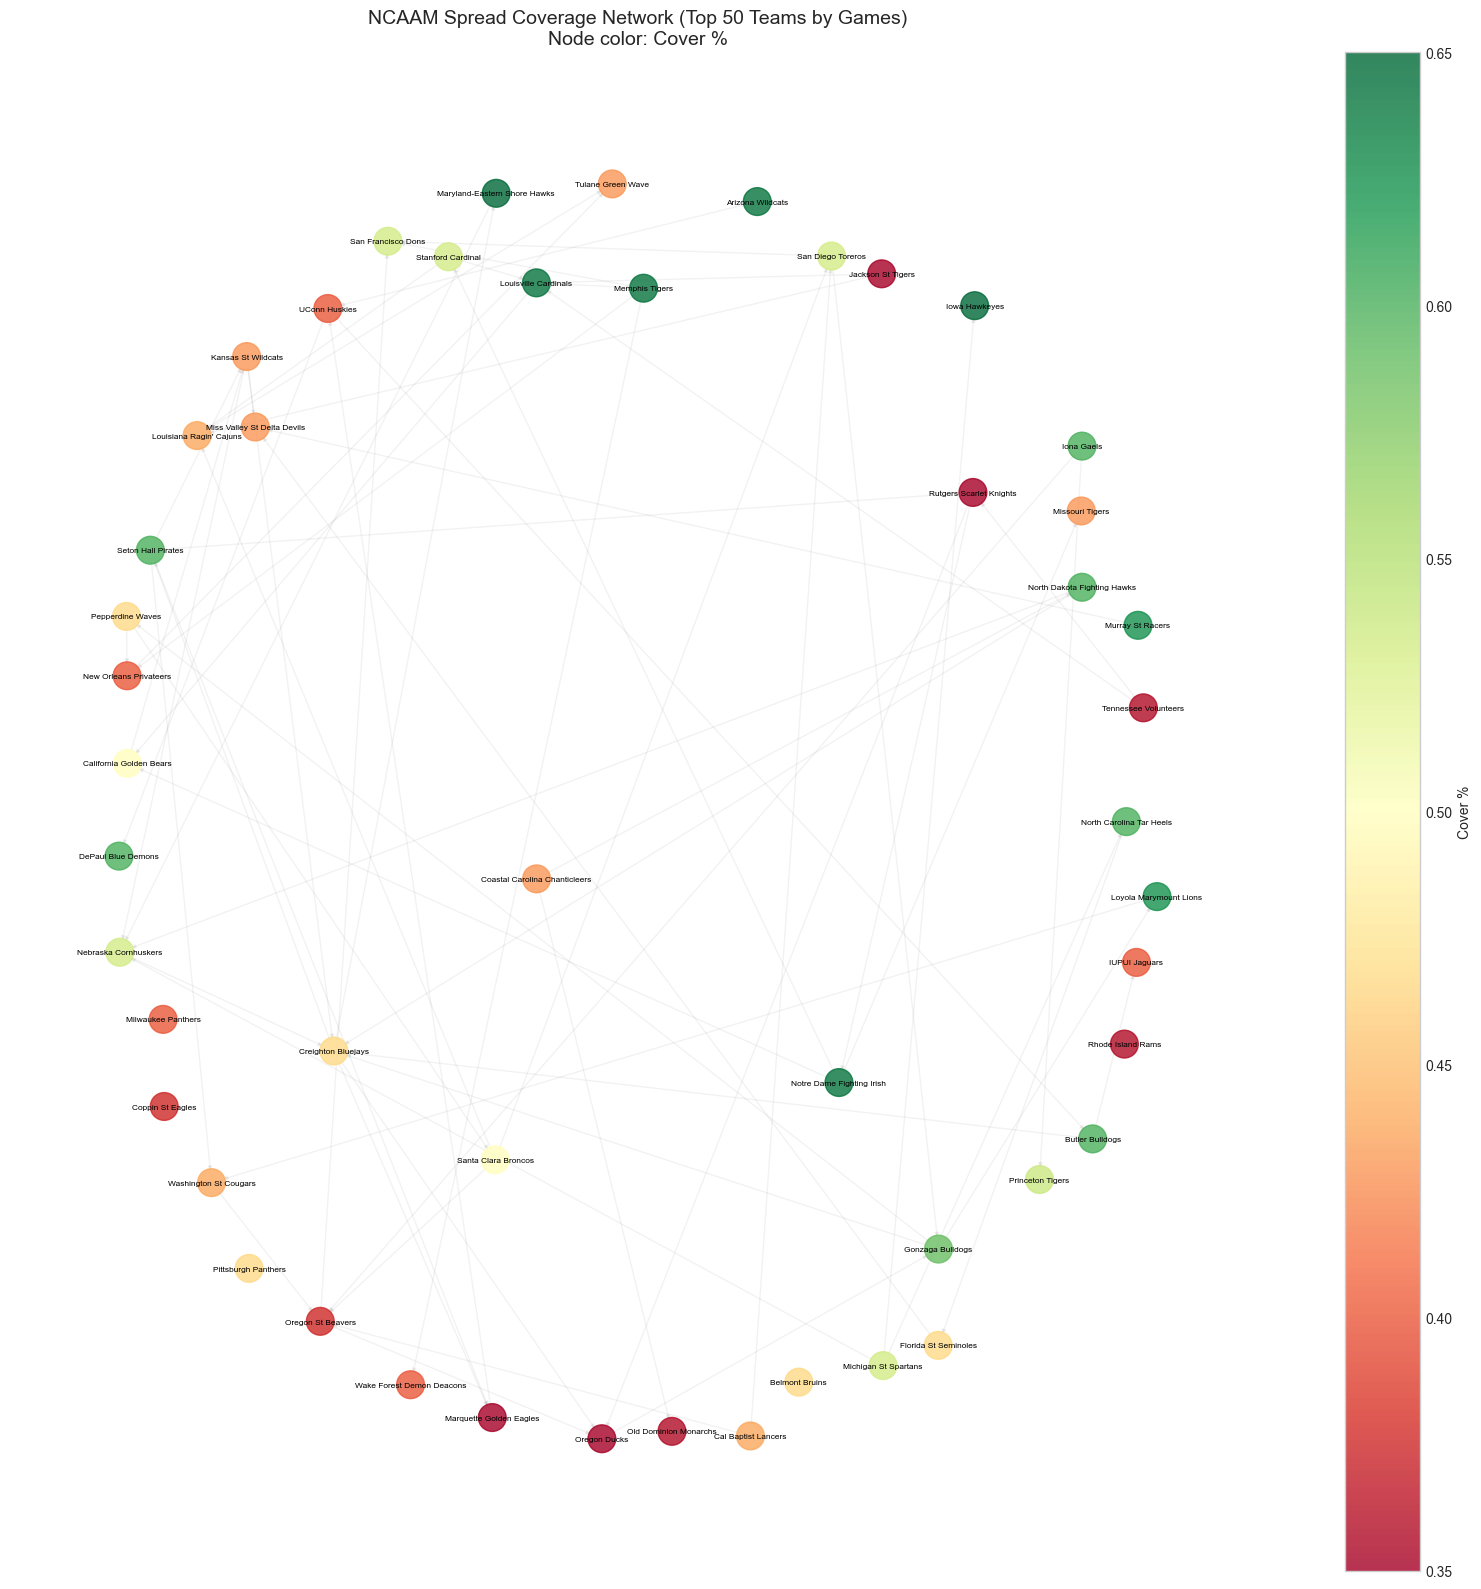

In [6]:
# Visualize the spread coverage network (subset for clarity)
# Use the largest connected component and sample top teams

# Calculate cover percentage
cover_counts = dict(G_spread.out_degree())
fail_counts = dict(G_spread.in_degree())
cover_pct = {
    team: cover_counts.get(team, 0) / (cover_counts.get(team, 0) + fail_counts.get(team, 0) + 0.001)
    for team in active_teams
}

# Get top 50 teams by total games for visualization
top_teams = sorted(team_game_counts.keys(), key=lambda t: team_game_counts.get(t, 0), reverse=True)[:50]
top_teams = [t for t in top_teams if t in active_teams]

# Create subgraph
G_sub = G_spread.subgraph(top_teams)

fig, ax = plt.subplots(figsize=(16, 16))

# Node colors based on cover%
node_colors = [cover_pct.get(node, 0.5) for node in G_sub.nodes()]

# Layout
pos = nx.spring_layout(G_sub, k=3, iterations=100, seed=42)

# Draw
nodes = nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, cmap=plt.cm.RdYlGn,
                               node_size=400, alpha=0.8, vmin=0.35, vmax=0.65, ax=ax)
nx.draw_networkx_labels(G_sub, pos, font_size=6, ax=ax)
nx.draw_networkx_edges(G_sub, pos, alpha=0.1, arrows=True,
                       edge_color='gray', arrowsize=6, ax=ax)

ax.set_title(f'NCAAM Spread Coverage Network (Top {len(top_teams)} Teams by Games)\nNode color: Cover %', fontsize=14)
fig.colorbar(nodes, ax=ax, label='Cover %')
ax.axis('off')
plt.tight_layout()
plt.show()

## Phase 3: Iterative Spread Coverage Rating

In [7]:
def compute_spread_coverage_rating(games_df, teams, max_iterations=150, tolerance=0.0005, 
                                    margin_cap=12, learning_rate=0.03):
    """
    Compute network-propagated spread coverage ratings.
    
    Algorithm:
    1. Initialize all teams with rating = 0.5
    2. For each game:
       - Expected outcome based on current ratings
       - Surprise factor = 1 - expected
       - Adjustment = surprise * cover_margin (capped) * learning_rate
       - Cover team rating += adjustment, Fail team -= adjustment
    3. Normalize to [0, 1]
    4. Repeat until convergence
    """
    # Initialize ratings
    ratings = {team: 0.5 for team in teams}
    
    history = []
    
    for iteration in range(max_iterations):
        new_ratings = ratings.copy()
        
        for _, game in games_df.iterrows():
            cover_team = game['cover_team']
            fail_team = game['fail_team']
            
            if cover_team not in teams or fail_team not in teams:
                continue
                
            cover_margin = min(game['cover_margin'], margin_cap)
            
            cover_rating = ratings[cover_team]
            fail_rating = ratings[fail_team]
            
            # Expected outcome
            total = cover_rating + fail_rating
            if total == 0:
                expected = 0.5
            else:
                expected = cover_rating / total
            
            # Surprise factor
            surprise = 1 - expected
            
            # Adjustment
            adjustment = surprise * (cover_margin / margin_cap) * learning_rate
            
            new_ratings[cover_team] += adjustment
            new_ratings[fail_team] -= adjustment
        
        # Normalize to [0, 1]
        min_r = min(new_ratings.values())
        max_r = max(new_ratings.values())
        if max_r > min_r:
            new_ratings = {t: (r - min_r) / (max_r - min_r) for t, r in new_ratings.items()}
        
        # Check convergence
        max_change = max(abs(new_ratings[t] - ratings[t]) for t in teams)
        history.append(max_change)
        
        if max_change < tolerance:
            print(f"Converged at iteration {iteration + 1}")
            break
        
        ratings = new_ratings
    
    return ratings, history

# Compute spread coverage ratings
spread_ratings, convergence_history = compute_spread_coverage_rating(
    df_spread_filtered,
    active_teams,
    max_iterations=CONFIG['iterations'],
    tolerance=CONFIG['tolerance'],
    margin_cap=CONFIG['margin_cap'],
    learning_rate=CONFIG['learning_rate']
)

# Display top teams by spread coverage rating
spread_ratings_df = pd.DataFrame([
    {'team': team, 'spread_coverage_rating': rating, 'games': team_game_counts.get(team, 0)}
    for team, rating in spread_ratings.items()
]).sort_values('spread_coverage_rating', ascending=False)

print("\nTop 15 Teams by Spread Coverage Rating:")
print(spread_ratings_df.head(15).to_string(index=False))


Top 15 Teams by Spread Coverage Rating:
                         team  spread_coverage_rating  games
Stephen F. Austin Lumberjacks                1.000000     13
                 Mercer Bears                0.899610      9
          Michigan Wolverines                0.894716     13
        Tarleton State Texans                0.847607     12
      Sam Houston St Bearkats                0.811352     11
                Buffalo Bulls                0.810836     12
         William & Mary Tribe                0.787016     12
         Illinois St Redbirds                0.730480     13
        Prairie View Panthers                0.703373     10
       Central Arkansas Bears                0.604912     10
                   LIU Sharks                0.604259     13
           Villanova Wildcats                0.600652     14
                Hofstra Pride                0.580307     11
       Tulsa Golden Hurricane                0.579444     12
                  UCF Knights               

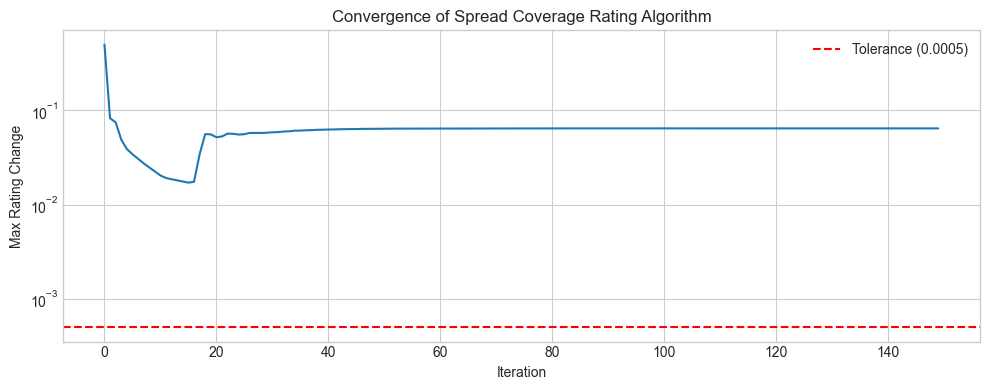

In [8]:
# Plot convergence
plt.figure(figsize=(10, 4))
plt.plot(convergence_history)
plt.axhline(y=CONFIG['tolerance'], color='r', linestyle='--', label=f"Tolerance ({CONFIG['tolerance']})")
plt.xlabel('Iteration')
plt.ylabel('Max Rating Change')
plt.title('Convergence of Spread Coverage Rating Algorithm')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

## Phase 4: Compare Spread Rating vs Win-Based Rating

In [9]:
# Compute traditional win-based rating for comparison
def compute_win_rating(games_df, teams, max_iterations=150, tolerance=0.0005, 
                       margin_cap=20, learning_rate=0.03):
    """Win-based network rating for comparison."""
    games = games_df.copy()
    games['home_margin'] = games['home_score'] - games['away_score']
    games['winner'] = np.where(games['home_margin'] > 0, games['home_team'],
                               np.where(games['home_margin'] < 0, games['away_team'], None))
    games['loser'] = np.where(games['home_margin'] > 0, games['away_team'],
                              np.where(games['home_margin'] < 0, games['home_team'], None))
    games['margin'] = games['home_margin'].abs()
    games = games[games['winner'].notna()]
    
    ratings = {team: 0.5 for team in teams}
    
    for iteration in range(max_iterations):
        new_ratings = ratings.copy()
        
        for _, game in games.iterrows():
            winner = game['winner']
            loser = game['loser']
            
            if winner not in teams or loser not in teams:
                continue
                
            margin = min(game['margin'], margin_cap)
            
            total = ratings[winner] + ratings[loser]
            expected = ratings[winner] / total if total > 0 else 0.5
            surprise = 1 - expected
            adjustment = surprise * (margin / margin_cap) * learning_rate
            
            new_ratings[winner] += adjustment
            new_ratings[loser] -= adjustment
        
        min_r, max_r = min(new_ratings.values()), max(new_ratings.values())
        if max_r > min_r:
            new_ratings = {t: (r - min_r) / (max_r - min_r) for t, r in new_ratings.items()}
        
        max_change = max(abs(new_ratings[t] - ratings[t]) for t in teams)
        if max_change < tolerance:
            break
        ratings = new_ratings
    
    return ratings

# Filter df to active teams
df_active = df[
    (df['home_team'].isin(active_teams)) & 
    (df['away_team'].isin(active_teams))
].copy()

# Compute win-based ratings
win_ratings = compute_win_rating(df_active, active_teams, margin_cap=20)

print(f"Win-based ratings computed for {len(win_ratings)} teams.")

Win-based ratings computed for 365 teams.


In [10]:
# Build comparison dataframe
team_stats = []

for team in active_teams:
    # Games data
    home_spread = df_spread_filtered[df_spread_filtered['home_team'] == team]
    away_spread = df_spread_filtered[df_spread_filtered['away_team'] == team]
    total_games = len(home_spread) + len(away_spread)
    
    # Win stats
    home_all = df_active[df_active['home_team'] == team]
    away_all = df_active[df_active['away_team'] == team]
    home_wins = (home_all['home_score'] > home_all['away_score']).sum()
    away_wins = (away_all['away_score'] > away_all['home_score']).sum()
    total_wins = home_wins + away_wins
    total_all = len(home_all) + len(away_all)
    
    # Cover stats
    home_covers = (home_spread['spread_result_difference'] >= 0).sum()
    away_covers = (away_spread['spread_result_difference'] < 0).sum()
    total_covers = home_covers + away_covers
    
    team_stats.append({
        'team': team,
        'games': total_games,
        'wins': total_wins,
        'win_pct': total_wins / total_all if total_all > 0 else 0,
        'covers': total_covers,
        'cover_pct': total_covers / total_games if total_games > 0 else 0,
        'win_rating': win_ratings.get(team, 0.5),
        'spread_rating': spread_ratings.get(team, 0.5)
    })

df_compare = pd.DataFrame(team_stats)

# Calculate Value Score
df_compare['value_score'] = df_compare['spread_rating'] - df_compare['win_rating']

df_compare = df_compare.sort_values('value_score', ascending=False)

print("Top 20 Teams by Value Score (Spread - Win Rating):")
print("="*90)
print(df_compare[['team', 'games', 'win_pct', 'cover_pct', 'win_rating', 'spread_rating', 'value_score']].head(20).to_string(index=False))

Top 20 Teams by Value Score (Spread - Win Rating):
                            team  games  win_pct  cover_pct  win_rating  spread_rating  value_score
                    Mercer Bears      9 0.333333   0.888889    0.179179       0.899610     0.720431
           Prairie View Panthers     10 0.100000   0.800000    0.059972       0.703373     0.643401
           Tarleton State Texans     12 0.583333   0.916667    0.230084       0.847607     0.617522
         Sam Houston St Bearkats     11 0.454545   0.818182    0.240508       0.811352     0.570844
   Stephen F. Austin Lumberjacks     13 0.769231   0.846154    0.477262       1.000000     0.522738
          Central Arkansas Bears     10 0.400000   0.600000    0.154752       0.604912     0.450161
                 Denver Pioneers     14 0.357143   0.714286    0.085724       0.524260     0.438537
            William & Mary Tribe     12 0.666667   0.833333    0.354554       0.787016     0.432462
                 Wagner Seahawks      9 0.333333 

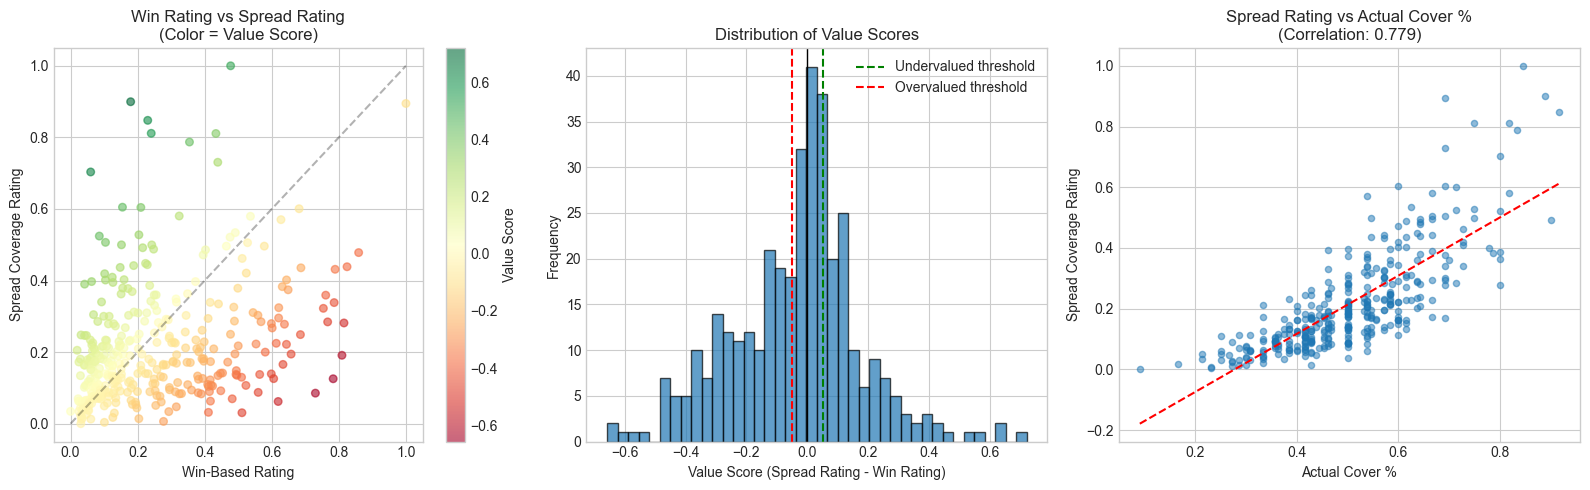


Correlation between Win Rating and Spread Rating: 0.334


In [11]:
# Visualize Win Rating vs Spread Rating
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Scatter: Win Rating vs Spread Rating
ax = axes[0]
colors = df_compare['value_score']
scatter = ax.scatter(df_compare['win_rating'], df_compare['spread_rating'], 
                     c=colors, cmap='RdYlGn', s=30, alpha=0.6)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Equal ratings')
ax.set_xlabel('Win-Based Rating')
ax.set_ylabel('Spread Coverage Rating')
ax.set_title('Win Rating vs Spread Rating\n(Color = Value Score)')
fig.colorbar(scatter, ax=ax, label='Value Score')

# Histogram of Value Scores
ax = axes[1]
ax.hist(df_compare['value_score'], bins=40, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.axvline(x=0.05, color='green', linestyle='--', label='Undervalued threshold')
ax.axvline(x=-0.05, color='red', linestyle='--', label='Overvalued threshold')
ax.set_xlabel('Value Score (Spread Rating - Win Rating)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Value Scores')
ax.legend()

# Correlation scatter
ax = axes[2]
corr = df_compare['win_rating'].corr(df_compare['spread_rating'])
ax.scatter(df_compare['cover_pct'], df_compare['spread_rating'], alpha=0.5, s=20)
ax.set_xlabel('Actual Cover %')
ax.set_ylabel('Spread Coverage Rating')
ax.set_title(f'Spread Rating vs Actual Cover %\n(Correlation: {df_compare["cover_pct"].corr(df_compare["spread_rating"]):.3f})')
z = np.polyfit(df_compare['cover_pct'], df_compare['spread_rating'], 1)
p = np.poly1d(z)
ax.plot(sorted(df_compare['cover_pct']), p(sorted(df_compare['cover_pct'])), 'r--')

plt.tight_layout()
plt.show()

print(f"\nCorrelation between Win Rating and Spread Rating: {corr:.3f}")

## Phase 5: Identify Undervalued & Overvalued Teams

In [12]:
# Define thresholds for undervalued/overvalued
value_threshold = 0.05
min_games_for_value = 10  # More games needed for reliable value assessment

# Filter to teams with sufficient games
df_compare_reliable = df_compare[df_compare['games'] >= min_games_for_value]

undervalued = df_compare_reliable[df_compare_reliable['value_score'] > value_threshold].sort_values('value_score', ascending=False)
overvalued = df_compare_reliable[df_compare_reliable['value_score'] < -value_threshold].sort_values('value_score')
fair_value = df_compare_reliable[(df_compare_reliable['value_score'] >= -value_threshold) & 
                                  (df_compare_reliable['value_score'] <= value_threshold)]

print("="*80)
print(f"MARKET INEFFICIENCY ANALYSIS (Teams with {min_games_for_value}+ games)")
print("="*80)

print(f"\n🟢 UNDERVALUED TEAMS ({len(undervalued)} teams)")
print("These teams cover spreads more often than their win record suggests.")
print("-"*80)
if len(undervalued) > 0:
    print(undervalued[['team', 'games', 'win_pct', 'cover_pct', 'win_rating', 'spread_rating', 'value_score']].head(15).to_string(index=False))
else:
    print("No significantly undervalued teams found.")

print(f"\n🔴 OVERVALUED TEAMS ({len(overvalued)} teams)")
print("These teams fail to cover spreads despite their win record.")
print("-"*80)
if len(overvalued) > 0:
    print(overvalued[['team', 'games', 'win_pct', 'cover_pct', 'win_rating', 'spread_rating', 'value_score']].head(15).to_string(index=False))
else:
    print("No significantly overvalued teams found.")

print(f"\n⚪ FAIR VALUE TEAMS ({len(fair_value)} teams)")
print("These teams cover spreads roughly in line with expectations.")

MARKET INEFFICIENCY ANALYSIS (Teams with 10+ games)

🟢 UNDERVALUED TEAMS (107 teams)
These teams cover spreads more often than their win record suggests.
--------------------------------------------------------------------------------
                            team  games  win_pct  cover_pct  win_rating  spread_rating  value_score
           Prairie View Panthers     10 0.100000   0.800000    0.059972       0.703373     0.643401
           Tarleton State Texans     12 0.583333   0.916667    0.230084       0.847607     0.617522
         Sam Houston St Bearkats     11 0.454545   0.818182    0.240508       0.811352     0.570844
   Stephen F. Austin Lumberjacks     13 0.769231   0.846154    0.477262       1.000000     0.522738
          Central Arkansas Bears     10 0.400000   0.600000    0.154752       0.604912     0.450161
                 Denver Pioneers     14 0.357143   0.714286    0.085724       0.524260     0.438537
            William & Mary Tribe     12 0.666667   0.833333    0.

## Phase 6: Predictive Analysis - Future Coverage Rate

In [13]:
# Split data into training and testing periods
df_spread_sorted = df_spread_filtered.sort_values('game_date')
split_idx = int(len(df_spread_sorted) * 0.75)

train_df = df_spread_sorted.iloc[:split_idx]
test_df = df_spread_sorted.iloc[split_idx:]

print(f"Training set: {len(train_df)} games ({train_df['game_date'].min().date()} to {train_df['game_date'].max().date()})")
print(f"Test set: {len(test_df)} games ({test_df['game_date'].min().date()} to {test_df['game_date'].max().date()})")

Training set: 1709 games (2025-11-03 to 2025-12-20)
Test set: 570 games (2025-12-20 to 2026-01-05)


In [14]:
# Compute spread rating on training data
train_teams = set(train_df['home_team']) | set(train_df['away_team'])
train_teams = train_teams.intersection(active_teams)

train_ratings, _ = compute_spread_coverage_rating(
    train_df,
    train_teams,
    max_iterations=CONFIG['iterations'],
    tolerance=CONFIG['tolerance'],
    margin_cap=CONFIG['margin_cap'],
    learning_rate=CONFIG['learning_rate']
)

# Calculate actual cover rate in test period
test_cover_rates = {}
test_game_counts = {}

for team in train_teams:
    home_test = test_df[test_df['home_team'] == team]
    away_test = test_df[test_df['away_team'] == team]
    
    total_test = len(home_test) + len(away_test)
    if total_test >= 3:  # Require at least 3 test games
        covers = (home_test['spread_result_difference'] >= 0).sum() + (away_test['spread_result_difference'] < 0).sum()
        test_cover_rates[team] = covers / total_test
        test_game_counts[team] = total_test

# Compare training spread rating to test cover rate
predictive_df = pd.DataFrame([
    {
        'team': team,
        'train_spread_rating': train_ratings.get(team, 0.5),
        'test_cover_rate': test_cover_rates.get(team, np.nan),
        'test_games': test_game_counts.get(team, 0)
    }
    for team in train_teams if team in test_cover_rates
])

# Correlation
pred_corr = predictive_df['train_spread_rating'].corr(predictive_df['test_cover_rate'])

print(f"\nPredictive Analysis:")
print(f"Teams with test data: {len(predictive_df)}")
print(f"Correlation between Training Spread Rating and Test Cover Rate: {pred_corr:.3f}")


Predictive Analysis:
Teams with test data: 302
Correlation between Training Spread Rating and Test Cover Rate: -0.057


/var/folders/jv/y3m0xwm544l00560wd0v47gh0000gn/T/ipykernel_98995/643705559.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_cover = predictive_df.groupby('tier')['test_cover_rate'].mean()


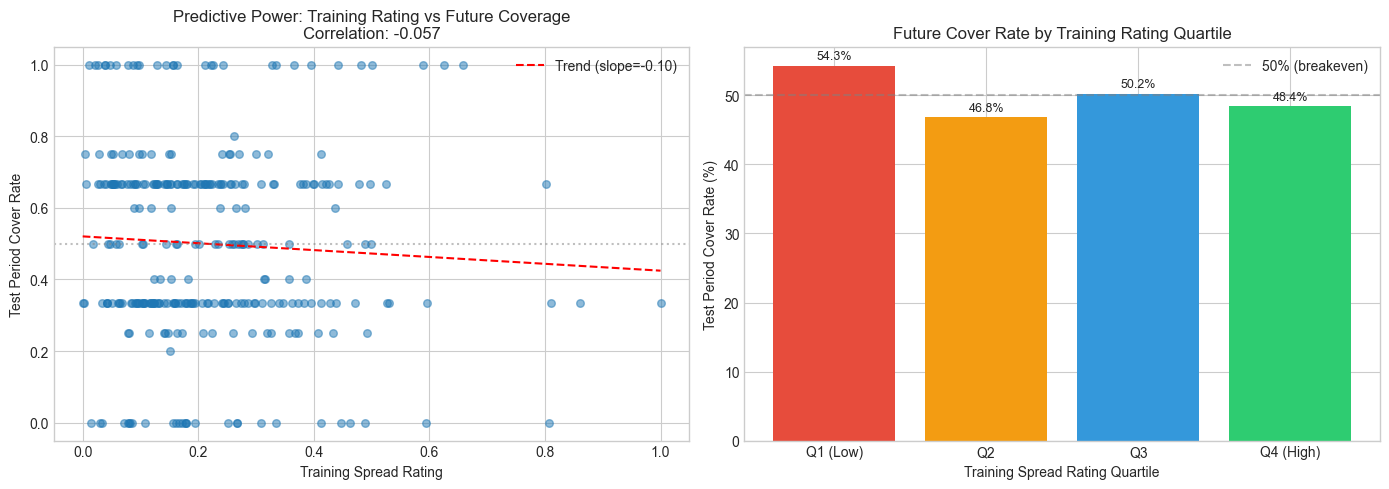

In [15]:
# Visualize predictive power
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: Training Rating vs Test Cover Rate
ax = axes[0]
ax.scatter(predictive_df['train_spread_rating'], predictive_df['test_cover_rate'], 
           alpha=0.5, s=30)
ax.set_xlabel('Training Spread Rating')
ax.set_ylabel('Test Period Cover Rate')
ax.set_title(f'Predictive Power: Training Rating vs Future Coverage\nCorrelation: {pred_corr:.3f}')

# Add trend line
z = np.polyfit(predictive_df['train_spread_rating'], predictive_df['test_cover_rate'], 1)
p = np.poly1d(z)
x_line = np.linspace(predictive_df['train_spread_rating'].min(), predictive_df['train_spread_rating'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', label=f'Trend (slope={z[0]:.2f})')
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.legend()

# Tier-based analysis
ax = axes[1]
try:
    predictive_df['tier'] = pd.qcut(predictive_df['train_spread_rating'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
    tier_cover = predictive_df.groupby('tier')['test_cover_rate'].mean()

    colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
    bars = ax.bar(tier_cover.index, tier_cover.values * 100, color=colors)
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% (breakeven)')
    ax.set_xlabel('Training Spread Rating Quartile')
    ax.set_ylabel('Test Period Cover Rate (%)')
    ax.set_title('Future Cover Rate by Training Rating Quartile')
    ax.legend()

    # Add value labels
    for bar, val in zip(bars, tier_cover.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val*100:.1f}%', 
                ha='center', fontsize=9)
except Exception as e:
    ax.text(0.5, 0.5, f"Could not create quartiles\n{str(e)}", ha='center', va='center')

plt.tight_layout()
plt.show()

## Phase 7: Conference-Level Analysis

In [16]:
# Analyze spread ratings by conference (if available)
# For NCAAM, identify clusters of teams that might represent conferences

# Use community detection to identify clusters
try:
    from networkx.algorithms import community
    
    # Convert to undirected for community detection
    G_undirected = G_spread.to_undirected()
    communities = list(community.louvain_communities(G_undirected, seed=42))
    
    print(f"Detected {len(communities)} communities (potential conference-like clusters)")
    
    # Assign community to each team
    team_community = {}
    for i, comm in enumerate(communities):
        for team in comm:
            team_community[team] = i
    
    # Add community to comparison df
    df_compare['community'] = df_compare['team'].map(team_community)
    
    # Community-level stats
    comm_stats = df_compare.groupby('community').agg({
        'team': 'count',
        'spread_rating': 'mean',
        'win_rating': 'mean',
        'value_score': 'mean',
        'cover_pct': 'mean'
    }).rename(columns={'team': 'teams'})
    
    # Filter to meaningful communities
    comm_stats = comm_stats[comm_stats['teams'] >= 5].sort_values('value_score', ascending=False)
    
    print(f"\nCommunity-Level Analysis (communities with 5+ teams):")
    print("="*80)
    print(comm_stats.round(3).to_string())
    
except ImportError:
    print("Community detection requires networkx >= 2.8. Skipping conference analysis.")
except Exception as e:
    print(f"Community detection failed: {e}")

Detected 5 communities (potential conference-like clusters)

Community-Level Analysis (communities with 5+ teams):
           teams  spread_rating  win_rating  value_score  cover_pct
community                                                          
2             72          0.265       0.256        0.008      0.515
0             57          0.211       0.236       -0.025      0.493
1             89          0.184       0.227       -0.044      0.499
4             76          0.229       0.276       -0.048      0.504
3             71          0.188       0.268       -0.080      0.495


## Summary & Recommendations

In [17]:
print("="*70)
print("NCAAM SPREAD COVERAGE NETWORK ANALYSIS: SUMMARY")
print("="*70)

print(f"\n1. DATA")
print(f"   - Total games with spread data: {len(df_spread)}")
print(f"   - Games between active teams: {len(df_spread_filtered)}")
print(f"   - Active teams ({CONFIG['min_games']}+ games): {len(active_teams)}")
print(f"   - Network edges: {G_spread.number_of_edges()}")
print(f"   - Network density: {nx.density(G_spread):.4f}")

win_spread_corr = df_compare['win_rating'].corr(df_compare['spread_rating'])
cover_spread_corr = df_compare['cover_pct'].corr(df_compare['spread_rating'])

print(f"\n2. RATING VALIDATION")
print(f"   - Win Rating vs Spread Rating correlation: {win_spread_corr:.3f}")
print(f"   - Actual Cover % vs Spread Rating correlation: {cover_spread_corr:.3f}")

print(f"\n3. MARKET INEFFICIENCIES (teams with {min_games_for_value}+ games)")
print(f"   - Undervalued teams: {len(undervalued)}")
print(f"   - Overvalued teams: {len(overvalued)}")
print(f"   - Fair value teams: {len(fair_value)}")

if len(undervalued) > 0:
    top_undervalued = undervalued.iloc[0]
    print(f"   - Most undervalued: {top_undervalued['team']} (value score: +{top_undervalued['value_score']:.3f})")
if len(overvalued) > 0:
    top_overvalued = overvalued.iloc[0]
    print(f"   - Most overvalued: {top_overvalued['team']} (value score: {top_overvalued['value_score']:.3f})")

print(f"\n4. PREDICTIVE POWER")
print(f"   - Teams with test data: {len(predictive_df)}")
print(f"   - Training-to-Test correlation: {pred_corr:.3f}")
if pred_corr > 0.3:
    print(f"   - Strong predictive signal detected")
elif pred_corr > 0.1:
    print(f"   - Moderate predictive signal detected")
else:
    print(f"   - Weak predictive signal - may be noise in sparse network")

print(f"\n5. NCAAM-SPECIFIC CONSIDERATIONS")
print(f"   - Sparse network (low density): requires careful interpretation")
print(f"   - Conference clustering affects common opponent paths")
print(f"   - Higher variance due to fewer games per team")

print(f"\n6. RECOMMENDATIONS")
if win_spread_corr < 0.8:
    print(f"   ✓ Spread rating captures different signal than win rating")
    print(f"   ✓ Value score may identify market inefficiencies")
else:
    print(f"   ⚠ Spread rating highly correlated with win rating")
    print(f"   ⚠ May not add significant value in NCAAM")

if pred_corr > 0.15:
    print(f"   ✓ Consider using spread rating for future predictions")
else:
    print(f"   ⚠ Combine spread rating with other features for predictions")

NCAAM SPREAD COVERAGE NETWORK ANALYSIS: SUMMARY

1. DATA
   - Total games with spread data: 2279
   - Games between active teams: 2279
   - Active teams (5+ games): 365
   - Network edges: 2273
   - Network density: 0.0171

2. RATING VALIDATION
   - Win Rating vs Spread Rating correlation: 0.334
   - Actual Cover % vs Spread Rating correlation: 0.779

3. MARKET INEFFICIENCIES (teams with 10+ games)
   - Undervalued teams: 107
   - Overvalued teams: 147
   - Fair value teams: 95
   - Most undervalued: Prairie View Panthers (value score: +0.643)
   - Most overvalued: UConn Huskies (value score: -0.657)

4. PREDICTIVE POWER
   - Teams with test data: 302
   - Training-to-Test correlation: -0.057
   - Weak predictive signal - may be noise in sparse network

5. NCAAM-SPECIFIC CONSIDERATIONS
   - Sparse network (low density): requires careful interpretation
   - Conference clustering affects common opponent paths
   - Higher variance due to fewer games per team

6. RECOMMENDATIONS
   ✓ Sprea

In [18]:
# Export team data with all metrics
export_df = df_compare[['team', 'games', 'wins', 'win_pct', 'covers', 'cover_pct',
                        'win_rating', 'spread_rating', 'value_score']].copy()
export_df = export_df.sort_values('spread_rating', ascending=False)

export_file = Path().resolve().parent / 'data' / 'results' / 'ncaam_spread_coverage_ratings.csv'
export_df.to_csv(export_file, index=False)
print(f"Exported spread coverage ratings to: {export_file}")

print(f"\nTop 15 Teams by Spread Coverage Rating:")
export_df.head(15)

Exported spread coverage ratings to: /Users/robertbatchelor/Documents/Projects/sports-betting/backend/data/results/ncaam_spread_coverage_ratings.csv

Top 15 Teams by Spread Coverage Rating:


,team,games,wins,win_pct,covers,cover_pct,win_rating,spread_rating,value_score
327,Stephen F. Austin Lumberjacks,13,10,0.769231,11,0.846154,0.477262,1.000000,0.522738
209,Mercer Bears,9,3,0.333333,8,0.888889,0.179179,0.899610,0.720431
252,Michigan Wolverines,13,13,1.000000,9,0.692308,1.000000,0.894716,-0.105284
167,Tarleton State Texans,12,7,0.583333,11,0.916667,0.230084,0.847607,0.617522
323,Sam Houston St Bearkats,11,5,0.454545,9,0.818182,0.240508,0.811352,0.570844
296,Buffalo Bulls,12,10,0.833333,9,0.750000,0.433348,0.810836,0.377488
291,William & Mary Tribe,12,8,0.666667,10,0.833333,0.354554,0.787016,0.432462
196,Illinois St Redbirds,13,10,0.769231,9,0.692308,0.438955,0.730480,0.291525
40,Prairie View Panthers,10,1,0.100000,8,0.800000,0.059972,0.703373,0.643401
43,Central Arkansas Bears,10,4,0.400000,6,0.600000,0.154752,0.604912,0.450161
